In [18]:
import os
import re
import matplotlib

import imageio
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from sys import argv
from scipy.special import factorial
from scipy.stats import poisson
import seaborn as sns
from scipy.special import factorial, gammaln
plt.style.use('seaborn-darkgrid')

### Acomodamos la data
Creamos un diccionario con los nombres de las carpetas y el contenido de ellas. Luego buscamOs las carpetas que tienen trace names diferentes y las agrupamos en distintos diccionarios uno para cada trace names.

obs: Tambien hay carpetas que tienen archivos bkp, esos si son necesarios habria que tomarlos tambien.

In [2]:
files = {os.path.splitext(k)[0]: {} for k in os.listdir('data/rawData')}

for i,file in enumerate(os.listdir('data/rawData')):
    name=str(os.path.splitext(file)[0])
    f = open(f'data/rawData/{name}/rawdataEMCCD.dat').read().split()
    files[name]=f
# Busco las carpetas que tienen trace names diferentes y las agrupo en distintos
# diccionarios uno para cada trace names.

# Tambien hay carpetas que tienen archivos bkp, esos si son necesarios habria que tomarlos tambien.
l=[]
l1=[]
l2=[]
l3=[]
l4=[]

for i in files:
    if files[i][14]=="866'":
        l.append(int(i))
    elif files[i][13]=="'rsbAx'":
        l1.append(int(i))
    elif files[i][13]=="'rsbRad1'":
        l2.append(int(i))
    elif files[i][13]=="'rsbRad2'":
        l3.append(int(i))
    elif files[i][13]=="'carrier":
        l4.append(int(i))

l=sorted(l)
l1=sorted(l1)
l2=sorted(l2)
l3=sorted(l3)
l4=sorted(l4)
print("Las carpetas con trace names 'without 866' 'with 866 and 854' son:")
print(l)
print('--------------------')
print("Las carpetas con trace names 'rsbAx' 'bsbAx' son:")
print(l1)
print('--------------------')
print("Las carpetas con trace names 'rsbRad1' 'bsbRad1' son:")
print(l2)
print('--------------------')
print("Las carpetas con trace names 'rsbRad2' 'bsbRad2' son:")
print(l3)
print('--------------------')
print("Las carpetas con trace names 'carrier dopp cool' 'carrier SB cool' son:")
print(l4)

# Armo los diccionarios para cada trace name
w866={}
rsbAx={}
rsbRad1={}
rsbRad2={}
cdc={}

# Lleno los diccionarios con sus respectivos archivos
for i in l:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][46:]:
            flo.append(float(j))
        w866[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][46:]:
            flo.append(float(j))
        w866[str(i)]=np.transpose(flo)

for i in l1:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbAx[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbAx[str(i)]=np.transpose(flo)

for i in l2:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbRad1[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbRad1[str(i)]=np.transpose(flo)

for i in l3:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][42:]:
            flo.append(float(j))
        rsbRad2[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][42:]:
            flo.append(float(j))
        rsbRad2[str(i)]=np.transpose(flo)

for i in l4:
    if i<8:
        flo=[]
        for j in files['0'+str(i)][46:]:
            flo.append(float(j))
        cdc[str(i)]=np.transpose(flo)
    else:
        flo=[]
        for j in files[str(i)][46:]:
            flo.append(float(j))
        cdc[str(i)]=np.transpose(flo)
        
# Arreglo los archivos de el diccionario file pero tomando desde el dato 46, me voy a comer alguno datos
# para algunos archivos

for i in files.keys():
    val=[]
    for j in files[i][46:]:
        val.append(float(j))
    files[i]=np.transpose(val)


Las carpetas con trace names 'without 866' 'with 866 and 854' son:
[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
--------------------
Las carpetas con trace names 'rsbAx' 'bsbAx' son:
[0, 4, 74, 75, 77, 78, 81, 82, 84, 85]
--------------------
Las carpetas con trace names 'rsbRad1' 'bsbRad1' son:
[1, 5]
--------------------
Las carpetas con trace names 'rsbRad2' 'bsbRad2' son:
[2, 6]
--------------------
Las carpetas con trace names 'carrier dopp cool' 'carrier SB cool' son:
[3, 7, 73, 76, 79, 80, 83]


### Hallando los paramteros $\lambda$
Los archivos estan cargados ahora en forma de arrays

In [3]:
def fit_function(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return  poisson.pmf(k, lamb)

def poisson_(k, lamb,a,offy,offx,b):
    """poisson pdf, parameter lamb is the fit parameter"""
    return a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy 

def poisson_approx(k, lamb,a,offy,offx,b):
    """poisson pdf, parameter lamb is the fit parameter"""
    return  a*(np.exp( (b*k+offx)*np.log(lamb)-lamb - gammaln *((b*k+offx) + 1)))+offy

def two_poisson(k, lamb,a,offy,offx,b, lamb2,a2,offy2,offx2,b2):
    sum_ =  (a*( (np.exp(-lamb) * lamb**(b*k+offx)) /factorial(b*k+offx) )+offy ) + (a2*( (np.exp(-lamb2) * lamb2**(b2*k+offx2)) /factorial(b2*k+offx2) )+offy2) 
    return sum_

In [6]:
dicts = [w866,rsbAx,rsbRad1,rsbRad2,cdc]

### Treshold de cada set de datos

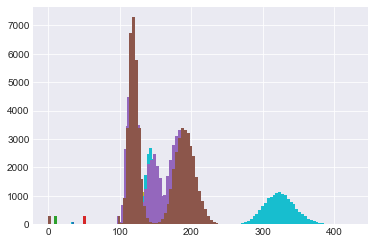

In [19]:
thresholds = {str(int(os.path.splitext(k)[0])): [] for k in os.listdir('data/rawData')}
from scipy import stats
from scipy.signal import find_peaks
from scipy import signal


for dict_ in dicts:
    for file in dict_:
        data = dict_[file]
        #plt.figure()
        entries, bin_edges, patches = plt.hist(data,bins=int(max(data)/4))
        x = np.delete(bin_edges,0,0)
        y = entries
        gauss = signal.windows.gaussian(len(x), std=3)
        blurred = signal.fftconvolve(y, gauss, mode='same')
        peaks, _ = find_peaks(blurred)
        #plt.scatter(x[peaks[-2:-1]],y[peaks[-2:-1]])
        #plt.scatter(x[peaks[-1]],y[peaks[-1]])
        #param, param_cov = curve_fit(two_poisson,x,y, p0=[90,10000,220,5,0.5,60,10000,220,10,0.5])
        #plt.plot(x,y,label=f'Original Data. arhc {file}')
        #plt.plot(x,blurred,label='Gauss')
        corte = peaks[-2:-1] + int((peaks[-1]-peaks[-2:-1])/2)
        thresholds[file] = (x[corte] - offset)/escala
        #plt.axvline(x[corte],color='red')
        #plt.plot(x,two_poisson(x,param[0],param[1],param[2],param[3],param[4],param[5],param[6],param[7],param[8],param[9]), label =f"Curve Fit Poisson",ls='dashed',color='red') 
        #plt.legend()
        #fig.savefig(f'figs/{file}.png')
        #parameters_[file] = param
        
        
        

In [7]:
A=0.49527485
B= -49.73544016
offset = -B/A
escala = 1/A

print(offset,escala)

100.41987829585936 2.0190809204222666


In [14]:
print(thresholds)

{'0': array([24.46513435]), '1': array([22.13154728]), '2': array([21.90831814]), '3': array([27.68840077]), '4': array([27.52743644]), '5': array([29.74818496]), '6': array([28.63571541]), '7': array([28.64180485]), '58': array([65.95376091]), '59': array([63.68250049]), '60': array([64.33733554]), '61': array([65.66359989]), '62': array([27.78522294]), '63': array([28.41852521]), '64': array([29.7716506]), '65': array([30.0863565]), '66': array([28.3198762]), '67': array([67.9892891]), '68': array([14.77135753]), '69': array([15.79561343]), '70': array([14.41916208]), '71': array([16.31376783]), '72': array([16.73199244]), '73': array([26.74255172]), '74': array([25.8824164]), '75': array([24.28859959]), '76': array([23.89247281]), '77': array([22.61278601]), '78': array([24.39819989]), '79': array([26.00167037]), '80': array([27.99475223]), '81': array([29.90795104]), '82': array([30.14760016]), '83': array([28.19605749]), '84': array([27.60408612]), '85': array([27.92325036])}


### Oscilaciones de Rabi

In [207]:
#ESTA DIVISION DE FILES ES LA CORRECTA

In [9]:
#files = {str(os.path.splitext(k)[0]): {} for k in os.listdir('data/rawData')}
files = {}
for i,file in enumerate(os.listdir('data/rawData')):
    name=str(os.path.splitext(file)[0])
    f = open(f'data/rawData/{name}/rawdataEMCCD.dat').read()
    f = f.split('\n')[6:-1]
    f = [i.split('\t')[:-1] for i in f]
    f = np.matrix(f)
    files[str(int(name))]=f
    
#for i in files:
#    print(files[i][0].shape())
        
#np.matrix(files['66'][1]).astype(np.float)



C:\Users\Luna\anaconda3.2\lib\site-packages\numpy\matrixlib\defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


(304, 22)
23.892472808750007
(304, 102)
26.001670369838717
(304, 202)
27.99475222588709


<ipython-input-16-68f7ac270b2d>:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col = np.squeeze(np.asarray(col)).astype(np.float)


(301, 202)
28.196057487499996


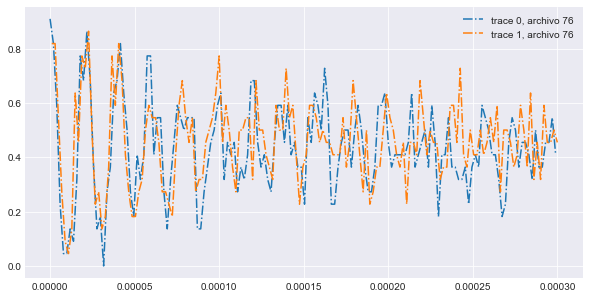

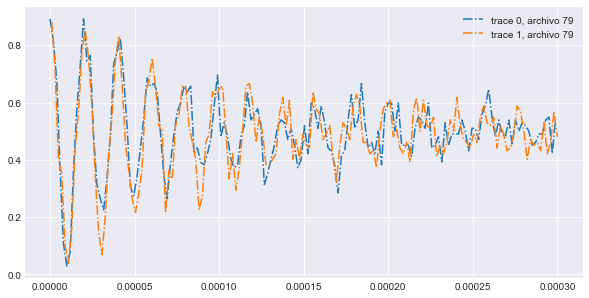

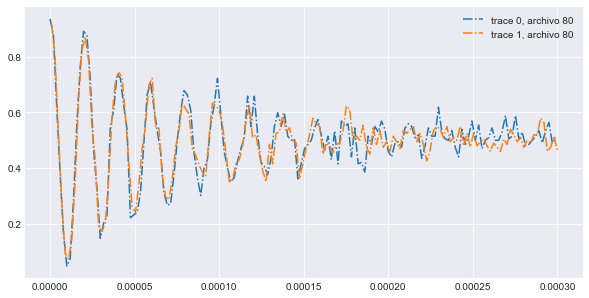

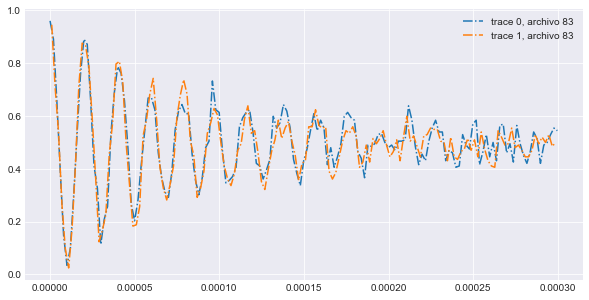

In [16]:
# aca estan las oscilacioens de rabi para TODOS los archivos jajaj
#en este dict voy a guardar los datos de las osc de rabi para los archivos '76', '79', '80', '83'

%matplotlib inline
fs = ['76', '79', '80', '83']
rabi = {f:{'t0': [],'trace_0': [],'error_0': [],'t1': [],'trace_1':[],'error_1': []} for f in fs}

for file in fs:
    data = files[file]
    trace_0 = []
    trace_1 = []
    t0 = []
    t1 = []
    error_0 = []
    error_1 = []
    
    
    print(data.shape)
    plt.figure(figsize=(10,5))
    thresh = thresholds[str(int(file))][0] #problema de notacion. arreglar esto
    print(thresh)
    #thresh = 22
    for i,col in enumerate(data):
        col = np.squeeze(np.asarray(col)).astype(np.float)
        N = int(len(col))
        if i % 2 == 0:
            t0.append(col[0])
            col = np.delete(col,0)
            col = (col-offset)/escala
            brill = [c for c in col if c>thresh]
            prob_brill = len(brill)/N
            err = np.sqrt(prob_brill*(1-prob_brill)/(N))
            error_0.append(err)
            trace_0.append(prob_brill)

        else:
            t1.append(col[0])
            col = np.delete(col,0)
            col = (col-offset)/escala
            brill = [c for c in col if c>thresh]
            prob_brill = len(brill)/N
            err = np.sqrt(prob_brill*(1-prob_brill)/(N))
            error_1.append(err)
            trace_1.append(prob_brill)
    

    rabi[file]['t0'] = t0
    rabi[file]['t1'] = t1
    rabi[file]['trace_0'] = trace_0
    rabi[file]['trace_1'] = trace_1
    rabi[file]['error_0'] = error_0
    rabi[file]['error_1'] = error_1
    plt.plot(t0,trace_0,label=f'trace 0, archivo {file}',ls='dashdot')
    plt.plot(t1,trace_1,label=f'trace 1, archivo {file}',ls='dashdot')
    plt.legend()
    


In [22]:
param, param_cov = curve_fit(RabiModel,t0,trace_0, p0=[16,53000,2300])
#param2, param_cov2 = curve_fit(poisson_approx,x,y, p0=[10,200,4,0.01,0.5])


#print("Covariance of coefficients:") 
#print(param_cov) 
print(f'm: {param[0]}')
print(f't: {Temp(param[0])}')



%matplotlib inline
plt.figure(figsize = (10,5))
#plt.plot(x,poisson_(x,90,21000,100))
plt.plot(t0,trace_0,label='Original Data')
plt.plot(to,RabiModel(t0,*param), label =f"Curve Fit Poisson",ls='dashed',color='red')

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

$P_g (t) = \frac{1}{2} [ 1 + \sum_{n=0} P_n cos(\Omega_{n,n+1} t)]$

Donde: 

$\Omega_{n,n+s} = \Omega_0 |<n+s| e^{i\eta (a + a^{x})} |n>| = \Omega e^{-\eta^2/2} \eta^{|s|} \sqrt{\frac{n<!}{n>!}} L_{n<}^{|s|}(\eta^2)$

Si s=0:   $\Omega_{n,n} =  \Omega_0 e^{-\eta^2/2} L_{n}^{0}(\eta^2)$

Y

$P_n = \frac{\bar{n}^{n}}{(\bar{n} + 1)^{n+1}}$



$P_g (t) = \frac{1}{2} [ 1 + P_0 cos(\Omega_{0,1} t) + P_1 cos(\Omega_{1,2} t)] = \frac{1}{2} [ 1 + \frac{1}{(\bar{n} + 1)} cos( \Omega_0 e^{-\eta^2/2} L_{0}(\eta^2) t) + \frac{\bar{n}}{(\bar{n} + 1)^{2}} cos( \Omega_0 e^{-\eta^2/2} L_{1}(\eta^2) t)] $

In [27]:
eta = 0.07 #lo dijo Christian en la clase
from scipy.special import comb
from scipy.special import genlaguerre

#Temperatura
def Temp(m):
    T=2*np.pi*6.62607015e-34*1e6/1.38e-23*(1/np.log((m+1)/m))
    return T


def Lag(n):
    c = genlaguerre(n, 0)(eta**2)
    
    return c

#  n barra ---> m

def RabiModel(t,m,omega0,gamma):
    n_max = 40
    eta=0.07
    Pn = 0 
    suma=[]
    for n in range(n_max):
        L = Lag(n)
        freq = omega0 * np.exp(-eta**2/2) * L 
        Pn = (m**n/((m+1)**(n+1)))*np.cos(freq * t ) # No sabia si era lo mismo asi que lo cambie jaja
        suma.append(Pn)
    P = (1+sum(suma)*np.exp(-gamma*t))/2
    return P

### Fitteo los trace 0 (Doppler)

In [18]:
%matplotlib inline
from lmfit import Model


In [44]:
#aprox un periodo 20 indexes
#agarro cuatro periodos y hago un fitteo continuo de omega

Temps_0 = {f: [] for f in fs}
for f in fs:
    x = rabi[f]['t0']
    y = rabi[f]['trace_0']
    for i in range(0,len(x)-80,2):
        t = 0
        tr = 0
        t = x[i:i + 80]
        tr = y[i:i + 80]
        
        mod = 0
        mod = Model(RabiModel)  
        pars = 0
        pars = mod.make_params()

        pars['m'].set(16,min=0)
        pars['omega0'].set(53000)
        pars['gamma'].set(3000)

        result = mod.fit(tr, pars, t=t,nan_policy='omit')
        T = Temp(result.values['m'])
        print(T)
        if T == np.nan:
            Temps_0[f].append(0) 
        else:
            Temps_0[f].append(T) 
        

1.7696484729984296
0.01617227423576158
5.762462335300851
64.16927456482863
18.059190134596996


ValueError: The array returned by a function changed size between calls

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


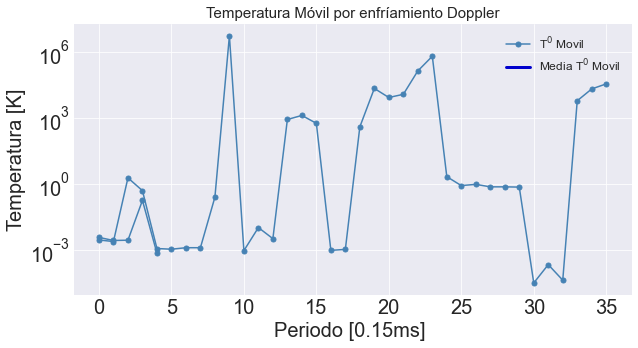

In [34]:
from numpy import * 
plt.figure(figsize=(10,5))
mean_0 = []
for f in fs:
    #label=r'T$^o$ movil SBC '
    if f != '83':
        T0 = np.array(Temps_0[f])
        plt.semilogy(T0,'-o',markersize=5,color='steelblue')
    else:
        T0 = np.array(Temps_0[f])
        plt.semilogy(T0,'-o',markersize=5,color='steelblue',label='T$^0$ Movil')
    
    nan_index = isnan(T0)
    T0[nan_index] = 0
    mean_0.append(np.array(T0))
    #plt.plot(Temps_1,'-o', label = 'T$^o$ movil SBC',markersize=5)
    plt.ylabel(r'Temperatura [K]',fontsize=20)
    plt.xlabel(r'Periodo [0.15ms] ',fontsize=20)
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    plt.legend(fontsize=13)
    

    
m0 = []
#mean_0 = np.transpose(mean_0)
for i in range(len(T0)):
    #print(np.mean(mean_1[i]))
    m0.append(np.mean(mean_0[i]))

plt.plot(m0, label='Media T$^0$ Movil',color='mediumblue',linewidth=3)
plt.title("Temperatura Móvil por enfríamiento Doppler",fontsize=15)
plt.legend(fontsize=12)

### Fitteo los trace 1 (SBC)

In [45]:
%matplotlib inline
from lmfit import Model

Temps_t1 = {f: [] for f in fs}

for f in fs:
    x = rabi[f]['t1']
    y = rabi[f]['trace_1']
    for i in range(0,len(x)-80,2):
        t = 0
        tr = 0
        t = x[i:i + 80]
        tr = y[i:i + 80]
        
        mod = 0
        mod = Model(RabiModel)  
        pars = 0
        pars = mod.make_params()

        pars['m'].set(20)
        pars['omega0'].set(53000)
        pars['gamma'].set(1000)

        result = mod.fit(tr, pars, t=t)
        print(result.values['m'])
        T = Temp(result.values['m'])
        Temps_t1[f].append(T) 

7311.44294286441
-7257.820389358557


ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


[0.003230496157461892, 0.0030621985011931308, 0.004227060728434404, 0.06466155311066098, 0.005817246404031606, 0.03214010494466777, 0.007954795935451392, 0.010116339583749209, 0.011865600521652938, 0.004426836807620312, 0.018566670299000106, 0.004728443073726782, 0.005818460372728889, 0.0010199411106819934, -0.0005927981101591776, -0.00013200603186374498, 0.32354695614899265, 0.10126319505185917, 0.10347556131721636, 0.0374491019306267, 0.03358699284527018, 0.02693384563116604, 0.057741925979528416, 0.013604029721182475, 0.0075221934167331575, 0.8128851090703877, 0.04071802139829106, 0.013826230777908993, 0.010412128469537827, 0.009641255244454063, 0.007373076150896344, 0.046252268327628486, 0.0639664492390783, 163.66783249378855, 1.9417780044130153]


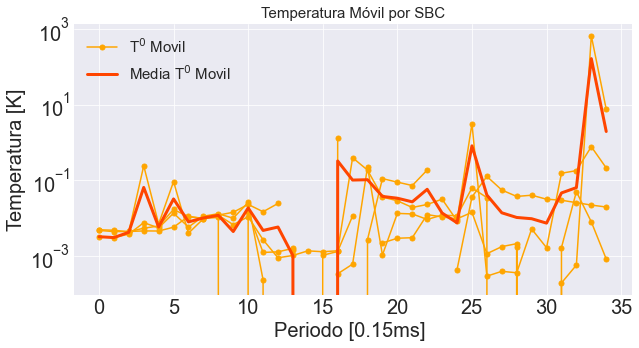

In [148]:
from numpy import *
plt.figure(figsize=(10,5))
mean_1 = []
for f in fs:
    #label=r'T$^o$ movil SBC '
    if f != '83':
        T1 = np.array(Temps_t1[f][1:])
        plt.semilogy(T1,'-o',markersize=5,color='orange')
    else:
        T1 = np.array(Temps_t1[f])
        plt.semilogy(T1,'-o',markersize=5,color='orange',label='T$^0$ Movil')
    
    nan_index = isnan(T1)
    T1[nan_index] = 0
    mean_1.append(np.array(T1))
    #plt.plot(Temps_1,'-o', label = 'T$^o$ movil SBC',markersize=5)
    plt.ylabel(r'Temperatura [K]',fontsize=20)
    plt.xlabel(r'Periodo [0.15ms] ',fontsize=20)
    plt.tick_params(axis="x", labelsize=20)
    plt.tick_params(axis="y", labelsize=20)
    plt.legend(fontsize=13)

m1 = []
mean_1 = np.transpose(mean_1)
for i in range(len(T1)):
    #print(np.mean(mean_1[i]))
    m1.append(np.mean(mean_1[i]))

plt.plot(m1,label='Media T$^0$ Movil',color='orangered',linewidth=3)
plt.title("Temperatura Móvil por SBC",fontsize=15)
plt.legend(fontsize=15)
print(m1)

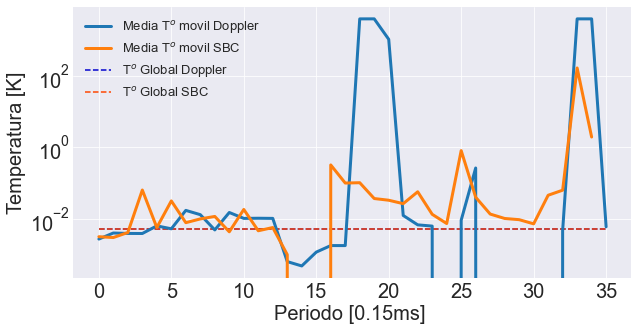

In [160]:
plt.figure(figsize=(10,5))
plt.semilogy(m0, label=r'Media T$^o$ movil Doppler ',linewidth=3)
plt.hlines(T_t0,0,35, ls='dashed',color='mediumblue',label=r'T$^o$ Global Doppler')
plt.plot(m1, label = 'Media T$^o$ movil SBC',linewidth=3)
plt.hlines(T_t0,0,35,ls='dashed', color='orangered',label=r'T$^o$ Global SBC')
plt.ylabel(r'Temperatura [K]',fontsize=20)
plt.xlabel(r'Periodo [0.15ms] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)

plt.legend(fontsize=13)

In [174]:
def lineal(x,m,b):
    return m*x + b



### Trial con un archivo solo (previo)

### 83: enfriamiento doppler

In [22]:
import numpy as np
f= open(f'data/rawData/83/rawdataEMCCD.dat').read()
#f = np.transpose(np.loadtxt('data/simple/RabiOsc_SBC_carrier_tobs=2ms.dat', delimiter=' '))
f = f.split('\n')[6:-1]
f = [i.split('\t')[:-1] for i in f]
f = np.matrix(f).astype(np.float)
f.shape
#f = np.transpose(f)

<ipython-input-22-2663535e14bb>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f = np.matrix(f).astype(np.float)


(301, 202)

In [23]:
dicts[-1].keys()

dict_keys(['3', '7', '73', '76', '79', '80', '83'])

No handles with labels found to put in legend.


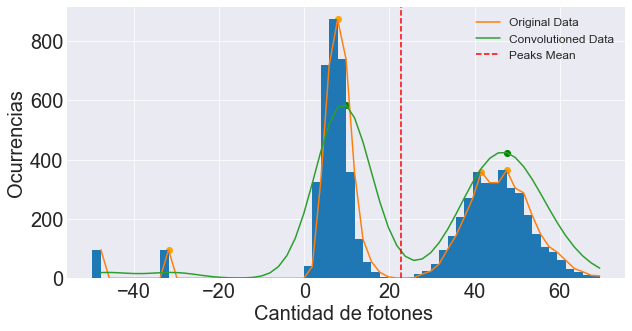

In [24]:
%matplotlib inline

data = dicts[-1]['3']
plt.figure(figsize=(10,5))
entries, bin_edges, patches = plt.hist((data-offset)/escala,bins=int(max(data)/4))
x = np.delete(bin_edges,0,0)
y = entries


gauss = signal.windows.gaussian(len(x), std=3)
blurred = signal.fftconvolve(y, gauss, mode='same')
peaks, _ = find_peaks(blurred)
peaks_o, _ = find_peaks(y)


plt.ylabel(r'Ocurrencias',fontsize=20)
plt.xlabel(r'Cantidad de fotones ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)

plt.plot(x,y,label='Original Data')
plt.plot(x,blurred/5,label='Convolutioned Data')
plt.scatter(x[peaks_o],y[peaks_o],color = 'orange')
plt.scatter(x[peaks[-2:-1]],blurred[peaks[-2:-1]]/5,color = 'green')
plt.scatter(x[peaks[-1]],blurred[peaks[-1]]/5,color='green')

corte = peaks[-2:-1] + int((peaks[-1]-peaks[-2:-1])/2)
thresholds[file] = x[corte]-5
plt.axvline(x[corte]-5,color='red',label='Peaks Mean',ls='dashed')
plt.legend(fontsize=12)
#fig.savefig(f'figs/{file}.png')
#parameters_[file] = param

In [369]:
len(f[0])
#np.squeeze(np.asarray(np.transpose(f)[0]))

1

<ipython-input-25-776d7c5e049c>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  col = np.squeeze(np.asarray(col)).astype(np.float)
No handles with labels found to put in legend.


201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201
201


<ErrorbarContainer object of 3 artists>

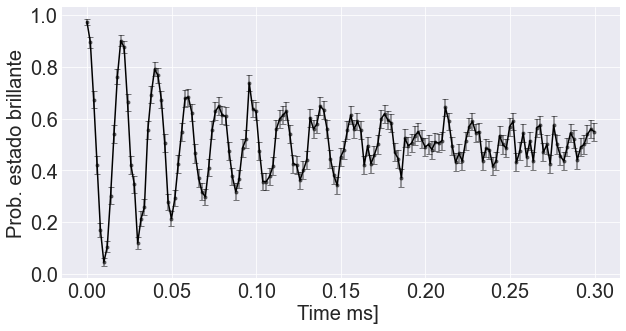

In [25]:
%matplotlib inline
trace_0 = []
trace_1 = []
error_0 = []
error_1 = []
#t = np.linspace(0,2,150)
t0 = []
t1= []
plt.figure(figsize=(10,5))
thresh = thresholds['83'][0]
for i,col in enumerate(f):
    col = np.squeeze(np.asarray(col)).astype(np.float)
    N = int(len(col))

    if i % 2 == 0:
        t0.append(col[0])
        col = np.delete(col,0)
        print(len(col))
        #aplicarle la transformacion a col aca. col = (col - offset)/ escala ??
        col = (col-offset)/escala
        brill = [c for c in col if c>thresh-5]
        prob_brill = len(brill)/N
        err = np.sqrt(prob_brill*(1-prob_brill)/(N))
        error_0.append(err)
        trace_0.append(prob_brill)
    else:
        t1.append(col[0])
        col = np.delete(col,0)
        col = (col-offset)/escala
        brill = [c for c in col if c>(thresh-5)]
        prob_brill = len(brill)/N
        err = np.sqrt(prob_brill*(1-prob_brill)/(N))
        error_1.append(err)
        trace_1.append(prob_brill)

plt.ylabel(r'Prob. estado brillante',fontsize=20)
plt.xlabel(r'Time ms] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)

plt.plot(np.array(t0)*1000,trace_0,'k')
#plt.plot(t1,trace_1)
plt.errorbar(np.array(t0)*1000,trace_0, yerr = error_0, fmt='.k',linewidth = 1.5, color = "black", alpha = 0.5, capsize = 3)
#plt.errorbar(t1,trace_1, yerr = error_1, fmt='.k',linewidth = 1.5, color = "black", alpha = 0.5, capsize = 3) 


In [66]:
i

300

In [67]:
Fs = 1/(t0[1] - t0[0])  #[kHz] Sample Frecuency
L = len(t0) 
freqs=np.fft.fftfreq(L,1/Fs) #frequency vector (x-axis in frec domain)
fft= np.abs(np.fft.fft(trace_0))
%matplotlib inline

#plt.plot(freqs[0:L//2],fft[0:L//2])
#p = plt.ginput(1)

In [184]:
print(f'w0 estimado:{p}')

NameError: name 'p' is not defined

Parameters([('m', <Parameter 'm', value=-inf, bounds=[-inf:inf]>), ('omega0', <Parameter 'omega0', value=-inf, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=-inf, bounds=[-inf:inf]>)])


No handles with labels found to put in legend.


[[Model]]
    Model(RabiModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 151
    # variables        = 3
    chi-square         = 0.40254404
    reduced chi-square = 0.00271989
    Akaike info crit   = -889.011820
    Bayesian info crit = -879.959981
[[Variables]]
    m:       16.5752401 +/- 1.79692217 (10.84%) (init = 0.9)
    omega0:  332412.155 +/- 708.053657 (0.21%) (init = 530000)
    gamma:   2861.79342 +/- 966.778407 (33.78%) (init = 30000)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, gamma)      = -0.817
    C(m, omega0)     =  0.597
    C(omega0, gamma) = -0.500


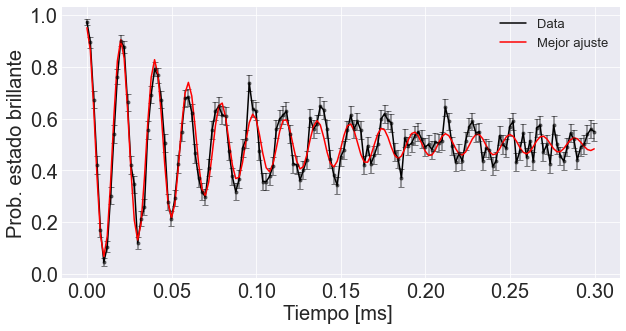

In [31]:
#TRACE 0
from lmfit import Model
mod = Model(RabiModel)   
pars = mod.make_params()
print(pars)

pars['m'].set(0.9, min = 0)
pars['omega0'].set(530000)
pars['gamma'].set(30000)

t0 = np.array(t0)

result = mod.fit(trace_0, pars, t=t0)

print(result.fit_report())
plt.figure(figsize=(10,5))
plt.ylabel(r'Prob. estado brillante',fontsize=20)
plt.xlabel(r'Tiempo [ms] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)
plt.legend(fontsize=15)

plt.plot(t0*1000, trace_0, 'k',label='Data')
plt.errorbar(np.array(t0)*1000,trace_0, yerr = error_0, fmt='.k',linewidth = 1.5, color = "black", alpha = 0.5, capsize = 3)
#plt.plot(t0, result.init_fit, 'k--', label='initial fit')
plt.plot(t0*1000, result.best_fit, 'r-', label='Mejor ajuste')
plt.legend(loc='best',fontsize=13)
plt.show()

In [33]:
error_0

[0.010931784482123279,
 0.021474441646620802,
 0.03300003251475394,
 0.034735642755569576,
 0.02632491909997708,
 0.0145168655662574,
 0.021474441646620802,
 0.03230333934426453,
 0.03506934617572469,
 0.029947041534768397,
 0.021014721442528764,
 0.023170189372822968,
 0.033249092897244384,
 0.034735642755569576,
 0.03348181029837589,
 0.022766096261620305,
 0.02880087854862527,
 0.030762402283135388,
 0.03497061032336771,
 0.032451352984143735,
 0.02855338376198557,
 0.02972950812671833,
 0.03300003251475394,
 0.035178152859519876,
 0.03149512868972046,
 0.02880087854862527,
 0.031993884333700276,
 0.03478973863750305,
 0.0350070190894218,
 0.03286925856194446,
 0.032734256113620776,
 0.034085134693431836,
 0.03509528312637157,
 0.03399424796750697,
 0.03273425611362078,
 0.03215087102308336,
 0.03461668472550727,
 0.03497061032336771,
 0.03399424796750697,
 0.033592147456427635,
 0.03425556142941642,
 0.03433515776032804,
 0.03513674242390668,
 0.034085134693431836,
 0.0327342561136

Parameters([('m', <Parameter 'm', value=-inf, bounds=[-inf:inf]>), ('omega0', <Parameter 'omega0', value=-inf, bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=-inf, bounds=[-inf:inf]>)])
[[Model]]
    Model(RabiModel)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 150
    # variables        = 3
    chi-square         = 2.89995994
    reduced chi-square = 0.01972762
    Akaike info crit   = -585.890756
    Bayesian info crit = -576.858850
[[Variables]]
    m:       136862.753 +/- 1.1816e+12 (863329452.12%) (init = 16)
    omega0: -3699830.77 +/- 8.3663e+12 (226126817.93%) (init = 53000)
    gamma:  -4912.48118 +/- 181878.137 (3702.37%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, omega0) =  1.000


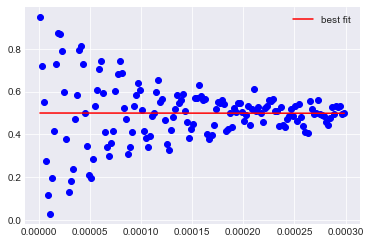

In [80]:
# TRACE 1
 
mod = Model(RabiModel)   
pars = mod.make_params()
print(pars)

pars['m'].set(16, min = 0)
pars['omega0'].set(53000)
pars['gamma'].set(1000)


result1 = mod.fit(trace_1, pars, t=t1)

print(result1.fit_report())
plt.figure()
plt.plot(t1, trace_1, 'bo')
#plt.plot(t0, result.init_fit, 'k--', label='initial fit')
plt.plot(t1, result1.best_fit, 'r-', label='best fit')
plt.legend(loc='best')
plt.show()

In [551]:
T_t0 = Temp(result.values['m'])
print(T_t0)
T_t1 = Temp(result1.values['m'])
print(T_t1)

0.005149870756172297
0.004380869708676011


In [48]:
T_t0 = 0.005149870756172297
T_t1 = 0.004380869708676011

In [32]:
0.004380869708676011/0.005149870756172297

0.8506756608261262

In [481]:
peaks, _ = find_peaks(result.best_fit)
print(peaks)
T = np.mean(np.array(t0)[peaks.astype(int)])
print(T)


[ 10  20  29  39  49  59  69  79  88  98 108 118 128 138 147]
0.00015704279999999998


#### Trace 0

In [45]:
#aprox un periodo 20 indexes
#agarro cuatro periodos y hago un fitteo continuo de omega

Temps_0 = []
for i in range(len(t0)-80):
    t = t0[i:i + 80]
    tr = trace_0[i:i + 80]
    
    mod = Model(RabiModel)   
    pars = mod.make_params()

    pars['m'].set(16,min=0)
    pars['omega0'].set(530000)
    pars['gamma'].set(10000)

    result = mod.fit(tr, pars, t=t)
    T = Temp(result.values['m'])
    print(T)
    Temps_0.append(T)
    



0.005302895978911856
0.005325249074112371
0.005265105099128871
0.00529888496883602
0.005166251528614512
0.005130138695878986
0.003197555055755485
0.005837840957340112
0.0067404121449164455
0.005104918935536681
0.005176057639356699
0.005291296159958815
0.018215459216661588
0.02553110436188251
0.013505872682254715
0.010382067171492464
0.001086618205267235
0.009118843477735991
0.02381624757401872
0.010270832716639497
0.010660035347816814
0.012739861686177014
0.002427707389868182
0.0021494369515362806
0.0020595056974484615
0.0005579077747352165
0.001085173648848901
0.001435030389945108
0.0014891782955980461
0.0018876052892719086
0.001719645705122557
0.0013410202637496621
0.0013401167640517335
0.0012708997087104833
0.0015242487348223843
5435.010305648199
0.5533074334196655
0.10855351448065244
0.15991349653024006
0.0859262212309174
0.03466204959443377
0.02416239501200415
0.026844366105375397
0.020931047530559427
0.017457601782742773
0.020215857169443525
0.024836278324784293
0.023002988955029

#### Trace 1

In [52]:
Temps_1 = []
for i in range(len(t1)-80):
    t = t1[i: i + 80]
    tr = trace_1[i:i + 80]
    
    mod = Model(RabiModel)   
    pars = mod.make_params()

    pars['m'].set(16)
    pars['omega0'].set(530000,min = 0)
    pars['gamma'].set(10000)

    result = mod.fit(tr, pars, t=t)
    T = Temp(result.values['m'])
    print(T)
    Temps_1.append(T)
    


0.0047789927708529216
0.004714324335484547
0.004448217216361921
0.004465718678229286
0.004437369575876869
0.0036610882261513406
0.00461791955984172
0.004892534504866881
0.0046791101533722465
0.0057627095993968026
0.005608415336518465
0.007082385217117907
0.010857589688737585
0.010088942750010786
0.010367142218695094
0.007565859069849562
0.010456040886482209
0.01496734398471283
0.011685364356991253
0.011512298962559819
0.013723783403095016
0.01944567856922852
0.0010980714973755292
0.0013435439380508915
0.001129960828263338
0.0009733189621853295
0.001548284355153396
0.001696947095842742
0.0019285998982588835
0.0020625818100392375
0.001518853853305169
0.00046779847281683056
0.0002611672979991217
0.00046904611889383345
0.0010533308583961243
0.0019634577748771
0.0021085409406372243
0.06370533355884832
0.01696105024263995
0.01580986239775174
0.01150212067316411
0.011794658441020567
0.011329897626642644
0.009500407045080077
0.008335363637626285
0.009351382107668497
0.010354030383049691
0.0101

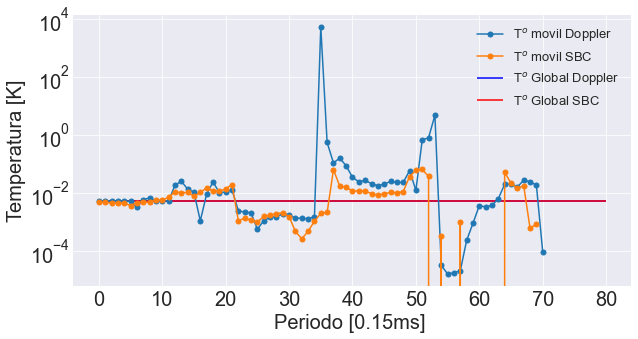

In [57]:
plt.figure(figsize=(10,5))
plt.semilogy(Temps_0,'-o', label=r'T$^o$ movil Doppler ',markersize=5)
plt.hlines(T_t0,0,80, color='blue',label=r'T$^o$ Global Doppler')
plt.plot(Temps_1,'-o', label = 'T$^o$ movil SBC',markersize=5)
plt.hlines(T_t0,0,80, color='red',label=r'T$^o$ Global SBC')
plt.ylabel(r'Temperatura [K]',fontsize=20)
plt.xlabel(r'Periodo [0.15ms] ',fontsize=20)
plt.tick_params(axis="x", labelsize=20)
plt.tick_params(axis="y", labelsize=20)

plt.legend(fontsize=13)

In [567]:
(t0[1] - t0[0]) * 80

0.00015984000000000001